In [1]:
from fastai.collab import * 
import pandas as pd
import codecs
import numpy as np
import json
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
import nltk, string
from sklearn.feature_extraction.text import TfidfVectorizer
from pyspark.ml.feature import HashingTF, IDF


In [2]:
disciplines = ['math|algebra|geometry', 'physic', 'chemic', 
               'biolog|cell|nature|physiolo', 
               'sociol|politic|legislativ|social network|social behavior', 
               'econo|management|financ|welfare',
               'computi|artificial intelligence|computer|acm |algori',
               'ieee|electronic']

In [38]:
#df_raw0 = pd.read_json(codecs.open('data/dblp-ref-0.json', 'r', 'utf-8'), orient = 'columns', lines = True)
#df_raw0[200000:].to_csv('raw0.csv')
#df_raw1 = pd.read_json(codecs.open('data/dblp-ref-1.json', 'r', 'utf-8'), orient = 'columns', lines = True)
#df_raw1.to_csv('raw1.csv')

In [39]:
#df_raw2 = pd.read_json(codecs.open('data/dblp-ref-2.json', 'r', 'utf-8'), orient = 'columns', lines = True)
#df_raw2.to_csv('raw2.csv')
#df_raw3 = pd.read_json(codecs.open('data/dblp-ref-3.json', 'r', 'utf-8'), orient = 'columns', lines = True)
#df_raw3.to_csv('raw3.csv')

In [3]:
df_raw0 = pd.read_json(codecs.open('data/dblp-ref-0.json', 'r', 'utf-8'), orient = 'columns', lines = True)
df_raw0['venue'] = df_raw0['venue'].str.lower()
df_raw0['abstract'] = df_raw0['abstract'].str.lower()
df_raw1 = pd.read_json(codecs.open('data/dblp-ref-1.json', 'r', 'utf-8'), orient = 'columns', lines = True)
df_raw1['venue'] = df_raw1['venue'].str.lower()
df_raw1['abstract'] = df_raw1['abstract'].str.lower()
df_raw2 = pd.read_json(codecs.open('data/dblp-ref-2.json', 'r', 'utf-8'), orient = 'columns', lines = True)
df_raw2['venue'] = df_raw2['venue'].str.lower()
df_raw2['abstract'] = df_raw2['abstract'].str.lower()
df_raw3 = pd.read_json(codecs.open('data/dblp-ref-3.json', 'r', 'utf-8'), orient = 'columns', lines = True)
df_raw3['venue'] = df_raw3['venue'].str.lower()
df_raw3['abstract'] = df_raw3['abstract'].str.lower()

In [4]:
## import citation data, and only use econ journals for training
# filtering from over 4.1 million papers to  1.1 million papers
df = pd.DataFrame()
for dis in disciplines:
    
    temp = df_raw1[df_raw1['venue'].str.contains(dis)]

    temp2 = df_raw2[df_raw2['venue'].str.contains(dis)]
    temp = temp.append(temp2)
    
    temp3 = df_raw3[df_raw3['venue'].str.contains(dis)]
    temp = temp.append(temp3)
    
    temp0 = df_raw0[df_raw0['venue'].str.contains(dis)]
    temp = temp.append(temp0)
    temp['discipline'] = dis
    df = df.append(temp)
    
len(df)

1185917

In [5]:
#remove papers that do not have abstracts
df = df[~df['abstract'].isnull()]
df = df.sort_values(['year','discipline'])
df['year'] = df['year'].astype(int)
len(df)

1051026

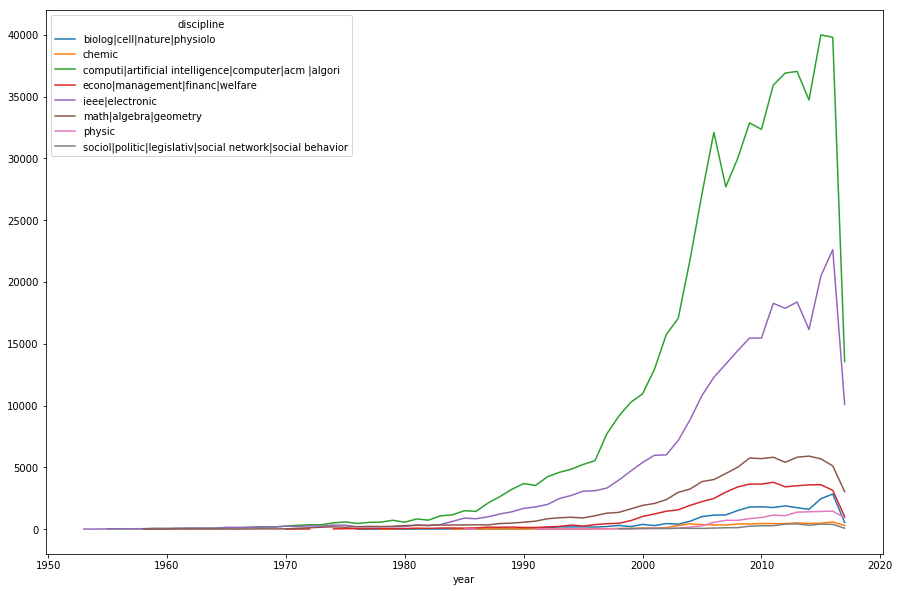

In [6]:
t = df.groupby(['year','discipline']).size().reset_index()
t = t.pivot(index = 'year', columns = 'discipline', values = 0)
t.plot.line(figsize = (15,10))

In [6]:
#df.to_csv('papers.csv')

There are different ways to measure similarity. 1. First, identify the group of similar papers, and see which papers are cited most  by But utimately, the goal is to provide suggestions on useful papers that are relevant to the field of 

If a paper belongs to two groups, we will compute the tf-idf for both groups, figure out the best 100 papers of the two groups.

In [14]:
len(df[200000:])

851026

Because the dataset is huge, we need some ways to restrict the dataset because we can compare citation pattern across that set. We follow the steps:
1. for each paper, restrict the set to other papers in their fields within +- 2 years.
2. Filter out papers that do not have any citations.
2. Use text similarity on the `abstract` further within the set of papers to top 1000. this is done by first computing the tf-idf features, then compute the cosine similarity between them by citation pattern.

3. Finally use citation by similar papers to calculate score.
4. upweight the paper with higher citation number.


In [7]:
years = range(df['year'].min(), df['year'].max()-1)#-1 for max years because our search sets search +1 year ahead
years_skip = range(df['year'].min(), df['year'].max(), 2)

In [8]:
years

range(1953, 2016)

In [9]:
stemmer = nltk.stem.porter.PorterStemmer()
remove_punctuation_map = dict((ord(char), None) for char in string.punctuation)

def stem_tokens(tokens):
    return [stemmer.stem(item) for item in tokens]

'''remove punctuation, lowercase, stem'''
def normalize(text):
    return stem_tokens(nltk.word_tokenize(text.lower().translate(remove_punctuation_map)))

vect = TfidfVectorizer(tokenizer=normalize, stop_words='english')

def cosine_sim(text1, text2):
    tfidf = vectorizer.fit_transform([text1, text2])
    return ((tfidf * tfidf.T).A)[0,1]


In [10]:
search_sets = []
for dis in disciplines:
    if (dis == 'computi|artificial intelligence|computer|acm |algori') | (dis == 'ieee|electronic'):
        for yr in years:
            search_set = dis + '_' + str(yr)
            search_sets.append(search_set)
    elif dis == 'math|algebra|geometry':
            search_set = dis + '_pre_2000'
            search_sets.append(search_set)
            for yr in range(2000, 2018):
                search_set = dis + '_' + str(yr)
                search_sets.append(search_set)
    else:
        search_set = dis
        search_sets.append(search_set)
len(search_sets)
        #for index, row in df.iterrows():
        #    if (row['discipline']==dis) & (row['year']==yr):
        #        row['search_set'] = dis + '_' + str(yr)

150

In [11]:
search_sets.index('computi|artificial intelligence|computer|acm |algori_2005')

76

In [15]:
# for each paper, assign a subset search for. the subset is unique to each paper.
 
def return_search_set_df(search_set):
    
    if search_set == 'math|algebra|geometry_pre_2000':
        search_set_df = df[(df['year']<2000)
               &(df['discipline']=='math|algebra|geometry')]
        return search_set_df
        
    else:
        disc = search_set.split('_')[0]
        if disc == 'computi|artificial intelligence|computer|acm |algori' or disc == 'ieee|electronic':
            yr = int(search_set[-4:])
            print(yr)
            if yr < 1999:
                search_set_df = df[df['year'].between(yr-2, yr+3, inclusive=True) 
                   &(df['discipline']==disc)]
            elif (yr >= 1999) & (yr <2005):
                search_set_df = df[df['year'].between(yr-0, yr+1, inclusive=True) 
                   &(df['discipline']==disc)]
            elif (yr >= 2005) & (yr <2019):
                search_set_df = df[df['year'].between(yr-0, yr+0, inclusive=True) 
                   &(df['discipline']==disc)]
        
        elif disc == 'math|algebra|geometry':
            yr = int(search_set[-4:])
            search_set_df = df[df['year'].between(yr-2, yr+3, inclusive=True) 
                   &(df['discipline']==disc)]
        else:
            search_set_df = df[(df['discipline']==disc)]
        return search_set_df
    


In [16]:
len(return_search_set_df('computi|artificial intelligence|computer|acm |algori_2005'))

2005


27136

In [17]:
#loopin through each search set, and calculate the cosine similarity, and then select the top 100 papers

for search_set in search_sets[76:]:
    print(search_set)
    search_set_df = return_search_set_df(search_set)
    tfidf = vect.fit_transform(search_set_df['abstract'])
    cos = (tfidf * tfidf.T).A
    paper_cosine = {}
    paper_most_sim = {}
    for i in range(len(search_set_df)-1):
        paper_cosine[search_set_df['id'].iloc[i]] = cos[i]
    ps_df = pd.DataFrame(paper_cosine)
    
    for i in range(len(search_set_df)-1):
        sim_papers = ps_df.iloc[i].nlargest(51).index.tolist()
        # drop the first paper - which is the paper itself
        paper_most_sim[search_set_df['id'].iloc[i]] = sim_papers[1:]    
    paper_most_sim = pd.DataFrame(paper_most_sim).transpose()
    
    
    paper_most_sim.to_csv(search_set+'.csv')
    #results = results.append(paper_most_sim)
    print(len(paper_most_sim))
    

computi|artificial intelligence|computer|acm |algori_2005
2005


/usr/local/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not in stop_words.
  'stop_wor

27135
computi|artificial intelligence|computer|acm |algori_2006
2006
32104
computi|artificial intelligence|computer|acm |algori_2007
2007
27696
computi|artificial intelligence|computer|acm |algori_2008
2008
29983
computi|artificial intelligence|computer|acm |algori_2009
2009
32867
computi|artificial intelligence|computer|acm |algori_2010
2010
32347
computi|artificial intelligence|computer|acm |algori_2011
2011
35927
computi|artificial intelligence|computer|acm |algori_2012
2012
36898
computi|artificial intelligence|computer|acm |algori_2013
2013
37036
computi|artificial intelligence|computer|acm |algori_2014
2014
34715
computi|artificial intelligence|computer|acm |algori_2015
2015
39987
ieee|electronic_1953
1953
54
ieee|electronic_1954
1954
82
ieee|electronic_1955
1955
116
ieee|electronic_1956
1956
170
ieee|electronic_1957
1957
220
ieee|electronic_1958
1958
262
ieee|electronic_1959
1959
319
ieee|electronic_1960
1960
368
ieee|electronic_1961
1961
414
ieee|electronic_1962
1962
495
ieee|e

In [19]:
results = pd.DataFrame()
for search_set in search_sets:
    temp = pd.read_csv(search_set+'.csv')

    results = results.append(temp)
print(len(results))


2067940


AttributeError: 'DataFrame' object has no attribute 'drop_duplicated'

In [22]:
results = results.drop_duplicates(subset = 'Unnamed: 0', keep = 'last')
print(len(results))

882630


In [25]:
results.rename(columns = {'Unnamed: 0': 'id'})
results.to_csv('recommended_papers.csv')

In [ ]:
#save recommendation results in csv

In [ ]:
pd.read_csv()

In [44]:
search_set_df = return_search_set_df('math|algebra|geometry_2010')
tfidf = vect.fit_transform(search_set_df['abstract'])
cos = (tfidf * tfidf.T).A


In [48]:
# top papers that resemble the paper by tf-idf similarity 
for i in range(len(search_set_df)-1):
    sim_papers = ps_df.iloc[i].nlargest(101).index.tolist()
    # drop the first paper - which is the paper itself
    paper_most_sim[search_set_df['id'].iloc[i]] = sim_papers[1:]    
paper_most_sim = pd.DataFrame(paper_most_sim).transpose()

In [49]:
paper_most_sim 

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
4aa69add-3978-480b-a1c0-d99a83d7e324,83bda85f-4765-4437-8ef1-1efe4bc08f53,f96fc4ba-1d68-4a67-92bc-7ad49ae8b8f6,e4d0da70-5fe2-4a57-9fe5-1ca003e4bdc3,a3c64193-7ec6-4e9f-bf67-e3d0e8e5bf38,05a404aa-f54d-401b-88de-2bae39720981,72015594-47e9-45e0-8609-67d5a077f393,5fb96d35-5093-4300-aefa-ad4a684edde1,e0330187-b957-4148-a3ad-3eed8d501cad,8318daf6-a0e8-4ad0-9746-b23b5ecd99c9,d74be9d7-aca4-4dff-a79f-03f8fb9c70cf,...,87ec9463-06c6-4b24-b42c-9be876873f85,74768fe6-2ff6-49f7-9a23-350a7b3090cd,ebd05b97-1971-4871-b0cc-0c36ca5c8ce7,8d0d4169-935e-44e3-a283-4ff39e512759,0691735c-9b1f-44ec-93a5-df4a4c4e8d9e,080093b5-2d12-43c0-a248-341719a2d429,03af609d-307c-43ac-89ca-8abd88362483,3256ffd7-1c54-4fa7-a04f-552995c2b0d4,644cab93-f669-4bf9-a4c5-8fac26ebbc4a,1b530dd8-628d-43cf-a2fe-cd72687ed2e7
4ad23e93-bf50-45bd-b19a-6801f7423c09,98f9be39-6ab6-48ee-8839-1f5a485e8452,d479d69e-5c93-4b8b-8b89-65f5d36a2a1c,fd468227-9cf8-4f28-a667-6bdbc74fcf39,61a49c33-d7c6-42ee-92ad-c243e69e621d,f8177a2d-1b41-4d63-a4c1-98eec9bf598e,40a094ab-70f5-4671-998f-7de69faed18a,f31a27cf-3881-4cd0-aa0e-365bf1fef64c,a75a634a-26c7-4f6e-b4db-020ef4ac34ab,5a8f8ba3-f1af-4fc7-b5a3-61bfd5e617af,9668d5c7-4765-4db3-bb8d-2c8d0b885839,...,a61a00b7-ffee-4e22-b02a-412afe876547,55440ceb-66d7-460e-8f31-028855a243a9,2facb943-f467-4745-ad82-9787ba2a543e,42bc04ef-6b15-493e-a49a-3a5df3f047a5,37f91524-3d16-4366-a1f3-3b720c712997,98820aaf-b5ef-41ad-90b8-4568c9c448c3,6f5f0a34-082b-4b44-bc61-00f75399360b,d4964a54-c2c9-4122-8a1c-308e7bcb9835,13bfb1b1-771b-41e1-a855-acf474d3b405,1f08660e-92c5-437e-8fd1-321d77e99934
4ae211b2-6c98-4a58-9e64-4865b507645c,6711a6ec-c150-41b9-b33c-bea23367b6cd,6c6ed473-460d-4e8b-ba6a-9bc49af729b0,88baf7de-02fd-4004-ae00-d4d2ba84a10a,7f2a4f8e-09a0-484e-bd2b-275a15e35118,78436454-caba-4dd5-a841-19a55e1b081a,e4653a77-0bc9-4668-95a6-3fee469aa71d,473b29aa-1f76-45da-8874-decb6b95d175,5e385132-680d-4c24-b002-d557dedf0c4d,baa827cb-c637-4fef-b01c-aa727905dbd7,5bb7924e-7d60-4fad-8a6c-d911573bd08f,...,97c606c9-7b69-4268-a232-a8e65352556e,dc422cae-f7d5-4c86-8c5a-19a09da77f09,c120b67c-1abf-46af-9c19-0e11c4a260d7,99826875-d94d-4a0a-a7b2-9fdcddce6633,cd4d4d19-1f10-43b9-b249-21040343e0e3,1a86ea58-f9c4-42b5-90d7-ecb8f2140179,b7ee31af-d280-497f-9a1e-9ece31254859,d496831b-84a2-447a-ba90-5b9f393d6815,ce076e6b-0bf7-4ad9-a934-07bb647211e4,0ff8c78a-8cc5-4b1f-b491-6d18a7507cb6
4ae31687-9798-4bef-a4cf-86e226943f2f,74281f5a-284a-4b4b-9eeb-69e77483501c,2e9d032d-22e5-4db9-afd7-2fa3535e51c5,ea7f6178-4bfb-4853-aec8-ca4421ad0bcb,9de58280-e163-4cf5-9308-1f7cf723fc9a,06e66989-42e6-4892-b5c4-68b3621e4027,c30df78f-a394-4544-88b1-2a86a6f0cf3d,73759a33-03ca-427d-b5d5-41ec27a0d89e,a2b75245-1935-4a24-9290-7a295c996eeb,d5d14b77-4917-42bb-88f9-08fe9baf7ee5,b5cdcf95-8c07-45f0-b8c5-51ab3ffd9b66,...,834b410e-6ad8-4177-86bd-48b57768ecd6,3137bb52-8c0c-4d6d-9fbc-6df22ea9e022,5bd29ab1-de1b-46a3-b022-7b7c501dfd03,4f92833b-d824-4dbd-b8d8-7aaa320f2368,5a32193a-34a7-4a1a-ad6e-c5f176b4026a,b4f74fb1-56d7-471c-b453-6d64d2e6ef66,072cce46-01d4-432d-b414-96a46feefcf2,3ebccb07-fe11-409c-a4a4-94233f71299b,51b64444-5bd8-4499-b3bc-f7a793b22943,4cc20f2d-5897-4289-a38d-5ca0b7e9013e
4ae3effe-1db1-46fa-a982-a89245fe1978,2160eb20-8a64-4374-82a2-be1bd8689ec6,29f42b97-dfd6-4396-9178-c2c83cbf61de,44daf782-a7b5-405c-9d74-99200cae97ca,e7c689ed-8dd9-458a-be27-aab3db789bba,a72d86c7-6ce2-4b40-8104-9b28c7a032a4,96ad402e-58f4-4637-aed0-0eceed4f5306,4d623275-3e17-4c1a-87ab-0d4656d010cc,5c4053f6-30e6-4d82-8852-bec5d086ca87,8f496ccd-8cd0-4d7f-be56-7395adfff580,6113f735-e8e2-4361-8161-73a4ea163e97,...,90967d99-6daa-4f76-b585-ea0205784cf1,f084e640-5f23-4f98-844e-7d1e1f1926dd,11b98906-226a-41af-9f47-7092804f119d,89daccda-29d4-45b2-9950-1709a5dacdee,ba1c1ca3-8a5f-4d1d-a96b-22703887aeb3,142b45e7-8f84-45b3-87f5-4c015c39b05d,5f40e80c-7ee8-4f90-8014-6b2fc420abf8,58647f25-23c6-4c0b-aee6-e059a3f38129,5835e031-3a58-4db4-ae6d-7ccd22bfa688,f02bea6d-cf50-4998-ab0c-b7b0aa5e17a4
4ae89277-7f8d-4683-b1c0-b21586905f2b,510

In [183]:
## the embedding gives a sense of the simiarities between the different movies by their citation patterns.

Fastai library is more suitable for data with varying scale. In this case we have binary data, (either you cited or not, so it may not be very informative). Instead we will follow https://medium.com/radon-dev/item-item-collaborative-filtering-with-binary-or-unary-data-e8f0b465b2c3 

In [80]:
temp = temp.pivot(index = 'references', columns = 'id', values = 'rating')

In [81]:
temp = temp.fillna(0)

In [82]:
print('number of papers citing the other paper:', len(temp.index), 'number of papers being cited:', len(temp.columns))

number of papers citing the other paper: 43259 number of papers being cited: 3994


In [83]:
### Compute Similarity 

In [84]:
magnitude = np.sqrt(np.square(temp).sum(axis=1))

In [85]:
temp = temp.divide(magnitude, axis='index')

In [86]:
def calculate_similarity(data_items):
    """Calculate the column-wise cosine similarity for a sparse
    matrix. Return a new dataframe matrix with similarities.
    """
    data_sparse = sparse.csr_matrix(data_items)
    similarities = cosine_similarity(data_sparse.transpose())
    sim = pd.DataFrame(data=similarities, index= data_items.columns, columns= data_items.columns)
    return sim

In [87]:
#transposing the matrix such that we use a paper's citation pattern (not how it is being cited) to calculate similarity
data_matrix = calculate_similarity(temp)

In [220]:
len(df)

2548532

In [88]:
#merge the data matrix with df so we know the name of the paper and the meta data

df_comp = pd.merge(data_matrix, df, left_index = True, right_on = 'id')

This paper that is most similar to other papers:

In [89]:
data_matrix.index

Index(['00026e34-c16c-4173-a612-2e86adb711b3',
       '0005d9a3-2b91-43c5-8866-558bb8b1f906',
       '00097174-5218-4064-a833-bf865b6eb833',
       '0021dc20-b314-4327-912f-91ff84cb6666',
       '0041327b-02b0-4557-9752-93a1c2c318a5',
       '00449b9c-a787-41a4-babf-405efc57b0f3',
       '006bf7c9-8626-4a9d-8c74-cd7343453975',
       '007fab92-9c44-4655-9e93-9011038bbcfb',
       '009d5731-52b1-4715-a045-fd537c10e7af',
       '009dc617-6b26-48e8-a492-9424a7457484',
       ...
       'ff45667c-e47c-4e7d-8e8f-e5b45305f1e9',
       'ff48dca5-3026-43ef-8cc5-9d2d735432a1',
       'ff59ec71-8a8d-4c6a-b403-e312c78e2570',
       'ff6486d6-570c-433b-bdf4-4e3e4273dbaa',
       'ff716897-4764-4460-9a30-f9d9ee16e1e7',
       'ff885d4c-5fdd-4958-b160-4d1b4fdecdb8',
       'ff9174df-15dd-4a88-acc1-156d8dfb638b',
       'ff92d4fa-5ce1-4b63-9fd9-8318c89a6507',
       'ff9cd93d-99b0-46a8-9b38-0636e7e7b9ed',
       'ffc13cbf-78b7-4927-ae54-50a338710ff2'],
      dtype='object', name='id', length=3994)

In [90]:
## loop through each paper and save the top 5 papers in a csv

results = {}
for paper in data_matrix.index:
    similar_papers = pd.merge(pd.DataFrame(data_matrix.loc[paper].nlargest(6)),
                      df_comp[['id','title','abstract']],
                      left_index = True,
                      right_on = 'id')['id'].tolist()
    if paper in similar_papers:
        similar_papers.remove(paper)
    results[paper] = similar_papers
    
    
        #drop the row where the id is the same as the one we search 

In [42]:
with open('paper_recommendations.json','w') as fp:
    json.dump(results, fp)

In [92]:
data_matrix

id,00026e34-c16c-4173-a612-2e86adb711b3,0005d9a3-2b91-43c5-8866-558bb8b1f906,00097174-5218-4064-a833-bf865b6eb833,0021dc20-b314-4327-912f-91ff84cb6666,0041327b-02b0-4557-9752-93a1c2c318a5,00449b9c-a787-41a4-babf-405efc57b0f3,006bf7c9-8626-4a9d-8c74-cd7343453975,007fab92-9c44-4655-9e93-9011038bbcfb,009d5731-52b1-4715-a045-fd537c10e7af,009dc617-6b26-48e8-a492-9424a7457484,...,ff45667c-e47c-4e7d-8e8f-e5b45305f1e9,ff48dca5-3026-43ef-8cc5-9d2d735432a1,ff59ec71-8a8d-4c6a-b403-e312c78e2570,ff6486d6-570c-433b-bdf4-4e3e4273dbaa,ff716897-4764-4460-9a30-f9d9ee16e1e7,ff885d4c-5fdd-4958-b160-4d1b4fdecdb8,ff9174df-15dd-4a88-acc1-156d8dfb638b,ff92d4fa-5ce1-4b63-9fd9-8318c89a6507,ff9cd93d-99b0-46a8-9b38-0636e7e7b9ed,ffc13cbf-78b7-4927-ae54-50a338710ff2
id,,,,,,,,,,,,,,,,,,,,,
00026e34-c16c-4173-a612-2e86adb711b3,1.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
0005d9a3-2b91-43c5-8866-558bb8b1f906,0.0,1.000000,0.0,0.009047,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
00097174-5218-4064-a833-bf865b6eb833,0.0,0.000000,1.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
0021dc20-b314-4327-912f-91ff84cb6666,0.0,0.009047,0.0,1.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
0041327b-02b0-4557-9752-93a1c2c318a5,0.0,0.000000,0.0,0.000000,1.0,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
00449b9c-a787-41a4-babf-405efc57b0f3,0.0,0.000000,0.0,0.000000,0.0,1.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
006bf7c9-8626-4a9d-8c74-cd7343453975,0.0,0.000000,0.0,0.000000,0.0,0.000000,1.000000,0.0,0.0,0.002502,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
007fab92-9c44-4655-9e93-9011038bbcfb,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,1.0,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000
009d5731-52b1-4715-a045-fd537c10e7af,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,1.0,0.000000,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000


In [93]:
result = pd.merge(pd.DataFrame(data_matrix.loc['00026e34-c16c-4173-a612-2e86adb711b3'].nlargest(11)),
         df_comp[['id','title','abstract']],
         left_index = True,
         right_on = 'id')


In [101]:
df_comp[df_comp[['id','title','abstract']]['id']=='61abfef1-6b9f-485b-9e88-d7d7a651f010']

,00026e34-c16c-4173-a612-2e86adb711b3,0005d9a3-2b91-43c5-8866-558bb8b1f906,00097174-5218-4064-a833-bf865b6eb833,0021dc20-b314-4327-912f-91ff84cb6666,0041327b-02b0-4557-9752-93a1c2c318a5,00449b9c-a787-41a4-babf-405efc57b0f3,006bf7c9-8626-4a9d-8c74-cd7343453975,007fab92-9c44-4655-9e93-9011038bbcfb,009d5731-52b1-4715-a045-fd537c10e7af,009dc617-6b26-48e8-a492-9424a7457484,...,ffc13cbf-78b7-4927-ae54-50a338710ff2,abstract,authors,id,n_citation,references,title,venue,year,discipline
640136,0.046464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,computing all abox repairs is a key to cautiou...,"[Jianfeng Du, Guilin Qi]",61abfef1-6b9f-485b-9e88-d7d7a651f010,1,"[291f6f98-4ffa-453c-a6fd-f64a3dbf7adb, 2f9abfd...",Tractable Computation of Representative ABox R...,knowledge science engineering and management,2015,math|algebra|geometry|
640136,0.046464,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,computing all abox repairs is a key to cautiou...,"[Jianfeng Du, Guilin Qi]",61abfef1-6b9f-485b-9e88-d7d7a651f010,1,"[291f6f98-4ffa-453c-a6fd-f64a3dbf7adb, 2f9abfd...",Tractable Computation of Representative ABox R...,knowledge science engineering and management,2015,econo|management|financ


In [99]:
pd.DataFrame(data_matrix.loc['00026e34-c16c-4173-a612-2e86adb711b3']).sort_index

<bound method DataFrame.sort_index of                                       00026e34-c16c-4173-a612-2e86adb711b3
id                                                                        
00026e34-c16c-4173-a612-2e86adb711b3                                   1.0
0005d9a3-2b91-43c5-8866-558bb8b1f906                                   0.0
00097174-5218-4064-a833-bf865b6eb833                                   0.0
0021dc20-b314-4327-912f-91ff84cb6666                                   0.0
0041327b-02b0-4557-9752-93a1c2c318a5                                   0.0
00449b9c-a787-41a4-babf-405efc57b0f3                                   0.0
006bf7c9-8626-4a9d-8c74-cd7343453975                                   0.0
007fab92-9c44-4655-9e93-9011038bbcfb                                   0.0
009d5731-52b1-4715-a045-fd537c10e7af                                   0.0
009dc617-6b26-48e8-a492-9424a7457484                                   0.0
00b8eb49-7a9f-46f8-8a15-6c4f46a06c90                          